In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import pickle
from scipy.stats import kstest
from collections import Counter
from scipy.stats import sem 
import pingouin as pg
import statsmodels.formula.api as smf
from statsmodels.stats.multitest import multipletests
import seaborn as sns

In [2]:
# INPUTS:

filepath = "F:/Two-Photon/Psilocybin Project/Evoked Cohort Mice/compiled_dicts"
z_thresh = 4

In [3]:
# Calculate the bandwidth of the cell using the half-max criterion, i.e. the continous range of responsive frequencies from the max response
# that show a response above 50% of the maximum response.  
# INPUTS:  Tuning array for the specified intensity (e.g. BF_column_1) in get_bandwidth_all_cells func.

def count_above_half_max(array):
    max_value = max(array)
    count = 0
    
    # Find the index of the maximum value in the array
    max_index = array.argmax()
    
    # Start from the index of the maximum value and iterate downwards
    index = max_index
    while index >= 0 and array[index] >= max_value / 2:
        count += 1
        index -= 1
    
    # Start from the index of the maximum value and iterate upwards
    index = max_index + 1  # Start from the next index
    while index < len(array) and array[index] >= max_value / 2:
        count += 1
        index += 1
    
    return count

In [4]:
# Dictionary to map filenames to variable names
file_variable_mapping = {
    'saline_pre_dict.pkl': 'saline_pre',
    'saline_post_dict.pkl': 'saline_post',
    'psilo_pre_dict.pkl': 'psilo_pre',
    'psilo_post_dict.pkl': 'psilo_post'
}

# Initialize empty dictionaries
saline_pre = {}
saline_post = {}
psilo_pre = {}
psilo_post = {}

# Iterate through files in megadict folder
for filename in os.listdir(filepath):
    if filename in file_variable_mapping:
        file_path = os.path.join(filepath, filename)
        with open(file_path, 'rb') as file:
            # Load pkl file and assign to respective dictionary variable
            globals()[file_variable_mapping[filename]] = pickle.load(file)

In [125]:
print(saline_pre['saline_1_186'][18]['peak_tuning'])

[[ 3.16538123e-01  1.77550443e+00  2.22869004e+00  5.66163589e-02]
 [ 2.00911175e-01  1.77368629e-01  2.40527420e-01  4.35925805e+00]
 [-2.52082877e-02  6.57310664e-02  2.33093291e-02  2.04954830e-01]
 [ 3.47114691e-01  4.41682848e-01  1.15507641e-01  3.05342290e-03]
 [ 7.07331762e-01  9.92378112e-01  7.26539551e-02  8.21607578e-01]
 [ 9.89843390e-01 -2.31348181e-02  9.78258737e-02  8.12818474e-02]
 [ 1.43558142e+00  6.04120067e-03  3.36815358e-01  1.14771081e+00]
 [ 1.22593969e-02  2.73537928e-01  6.21261304e-01  9.82298265e-02]
 [ 4.24616884e-02  4.82212575e-01  1.76020442e-02  1.15226519e-01]
 [ 9.06170423e-02  1.02153691e-01  8.15918672e-02  9.02214273e-03]
 [ 4.89330443e-02  5.67275012e-02 -6.88913318e-02  1.96792864e-01]
 [ 1.74754141e-02  1.15771675e-01  7.03608404e-02  7.25248793e-01]]


In [7]:
'''
Input: Collated all-animal dictionary for a given recording identity.
For a given recording dictionary (e.g. pre-saline, post-saline), identify if a cell is active, then for each sound level,
identify the bandwidth of response (measured by ful-width at half maximum of response) at that given level.
Output:  Stores the bandwidth value for each sound-level in an array, under 'bandwidth' key for that cell in the dict.
'''

def calculate_all_bandwidths(dict,No_sound_levels):

    sub_dict_keys = dict.keys()
    count = 0

    for sub_dict in sub_dict_keys:
        for cell in dict[sub_dict]:

            if dict[sub_dict][cell]['active'] == True:
                bandwidth_array = [0,0,0,0]
                count += 1

                for level in range(No_sound_levels):
                    level_array = dict[sub_dict][cell]['peak_tuning'][:,level]
                    if any(value >= z_thresh for value in level_array):
                        bandwidth_array[level] = count_above_half_max(level_array)
        
                dict[sub_dict][cell]['bandwidth'] = bandwidth_array
    print("The total number of cells in this cohort is", count)

        

In [151]:
'''
For each recording collated dict, process and add bandwidth values for all neurons identified as active.
'''

No_sound_levels = 4
calculate_all_bandwidths(saline_pre,No_sound_levels)
calculate_all_bandwidths(saline_post,No_sound_levels)
calculate_all_bandwidths(psilo_pre,No_sound_levels)
calculate_all_bandwidths(psilo_post,No_sound_levels)

The total number of cells in this cohort is 1307
The total number of cells in this cohort is 1222
The total number of cells in this cohort is 1194
The total number of cells in this cohort is 1214


In [9]:


def dict_to_pd_bandwidth(dict,condition):
    rows = []

    for mouse_id, mouse_data in dict.items():

        base_mouse_id = mouse_id[-3:]

        for cell_id, cell_data in mouse_data.items():

            if cell_data['active'] == True:
                unique_cell_id = f"{mouse_id}_{condition}_{cell_id}"
                row = {
                    'original_mouse_id': mouse_id,
                    'mouse_id': base_mouse_id,
                    'cell': cell_id,
                    'condition': condition,
                    'unique_cell_id': unique_cell_id,
                    'bandwidth_35': cell_data['bandwidth'][0],
                    'bandwidth_50': cell_data['bandwidth'][1],
                    'bandwidth_65': cell_data['bandwidth'][2],
                    'bandwidth_80': cell_data['bandwidth'][3]
                }
                rows.append(row)
    df = pd.DataFrame(rows)

    return df

In [10]:
rows_pre_saline = dict_to_pd_bandwidth(saline_pre,'pre')
rows_post_saline = dict_to_pd_bandwidth(saline_post,'post')

rows_pre_psilo = dict_to_pd_bandwidth(psilo_pre,'pre')
rows_post_psilo = dict_to_pd_bandwidth(psilo_post,'post')

saline_data = pd.concat([rows_pre_saline,rows_post_saline])
psilo_data = pd.concat([rows_pre_psilo,rows_post_psilo])
print(saline_data.shape)
print(psilo_data.shape)



(2529, 9)
(2408, 9)


In [11]:
# First, prepare data in long format
def prepare_for_anova(df):
    long_df = pd.melt(
        df, 
        id_vars=['mouse_id', 'cell', 'condition'],
        value_vars=['bandwidth_35', 'bandwidth_50', 'bandwidth_65', 'bandwidth_80'],
        var_name='bandwidth_level', 
        value_name='bandwidth_value'
    )
    # Extract numeric bandwidth level
    long_df['bandwidth_level'] = long_df['bandwidth_level'].str.extract('(\d+)').astype(int)
    return long_df

In [12]:
prepared_saline = prepare_for_anova(saline_data)
prepared_psilo = prepare_for_anova(psilo_data)


In [29]:
# Create separate dataframes for each bandwidth level
bandwidth_levels = [35, 50, 65, 80]
results = {}
print("Saline Data Results")
for bw in bandwidth_levels:
    # Filter data for this bandwidth level
    bw_data = saline_data[['mouse_id', 'unique_cell_id', 'condition', f'bandwidth_{bw}']]
    
    # Rename for clarity
    bw_data = bw_data.rename(columns={f'bandwidth_{bw}': 'bandwidth_value'})
    
    # Fit model for this bandwidth level
    model = smf.mixedlm(
        "bandwidth_value ~ condition", 
        bw_data, 
        groups=bw_data["mouse_id"]
    )
    
    try:
        # Store results if convergence successful
        results[bw] = model.fit()
        print(f"\nResults for bandwidth {bw}:")
        print(results[bw].summary().tables[1])  # Print only coefficients table
    except:
        print(f"\nConvergence failed for bandwidth {bw}")

Saline Data Results

Results for bandwidth 35:
                  Coef. Std.Err.      z  P>|z| [0.025 0.975]
Intercept         0.299    0.067  4.445  0.000  0.167  0.431
condition[T.pre]  0.052    0.024  2.199  0.028  0.006  0.098
Group Var         0.034    0.032                            

Results for bandwidth 50:
                  Coef. Std.Err.      z  P>|z| [0.025 0.975]
Intercept         0.371    0.067  5.548  0.000  0.240  0.502
condition[T.pre]  0.076    0.026  2.916  0.004  0.025  0.127
Group Var         0.033    0.028                            

Results for bandwidth 65:
                  Coef. Std.Err.      z  P>|z| [0.025 0.975]
Intercept         0.510    0.060  8.566  0.000  0.394  0.627
condition[T.pre]  0.074    0.032  2.326  0.020  0.012  0.136
Group Var         0.024    0.018                            

Results for bandwidth 80:
                  Coef. Std.Err.      z  P>|z| [0.025 0.975]
Intercept         0.545    0.066  8.226  0.000  0.415  0.675
condition[T.pre]  

In [28]:
# Create separate dataframes for each bandwidth level
bandwidth_levels = [35, 50, 65, 80]
results = {}
print("Psilocybin Data Results")
for bw in bandwidth_levels:
    # Filter data for this bandwidth level
    bw_data = psilo_data[['mouse_id', 'unique_cell_id', 'condition', f'bandwidth_{bw}']]
    
    # Rename for clarity
    bw_data = bw_data.rename(columns={f'bandwidth_{bw}': 'bandwidth_value'})
    
    # Fit model for this bandwidth level
    model = smf.mixedlm(
        "bandwidth_value ~ condition", 
        bw_data, 
        groups=bw_data["mouse_id"]
    )
    
    try:
        # Store results if convergence successful
        results[bw] = model.fit()
        print(f"\nResults for bandwidth {bw}:")
        print(results[bw].summary())  # Print only coefficients table
    except:
        print(f"\nConvergence failed for bandwidth {bw}")

Psilocybin Data Results

Results for bandwidth 35:


C:\Users\Conor\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\iolib\summary2.py:579: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  dat = dat.applymap(lambda x: _formatter(x, float_format))
C:\Users\Conor\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\iolib\summary2.py:579: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  dat = dat.applymap(lambda x: _formatter(x, float_format))
C:\Users\Conor\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\iolib\summary2.py:579: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  dat = dat.applymap(lambda x: _formatter(x, float_format))


            Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: bandwidth_value
No. Observations: 2408    Method:             REML           
No. Groups:       8       Scale:              0.3584         
Min. group size:  144     Log-Likelihood:     -2197.0128     
Max. group size:  481     Converged:          Yes            
Mean group size:  301.0                                      
-------------------------------------------------------------
                   Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------
Intercept           0.347    0.058  5.985 0.000  0.233  0.460
condition[T.pre]   -0.035    0.024 -1.412 0.158 -0.082  0.013
Group Var           0.024    0.023                           


Results for bandwidth 50:
            Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: bandwidth_value
No. Observations: 2408    Method:             REML           
No. 

C:\Users\Conor\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
C:\Users\Conor\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\statsmodels\iolib\summary2.py:579: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  dat = dat.applymap(lambda x: _formatter(x, float_format))


In [30]:
# Your bandwidth levels
bandwidth_levels = [35, 50, 65, 80]
pvalues = []
coefs = []
stderr = []

# Use the correct parameter name: 'condition[T.pre]'
param_name = 'condition[T.pre]'
for bw in bandwidth_levels:
    try:
        # Extract p-value, coefficient, and standard error
        pvalues.append(results[bw].pvalues[param_name])
        coefs.append(results[bw].params[param_name])
        stderr.append(results[bw].bse[param_name])
    except KeyError:
        print(f"Parameter '{param_name}' not found for bandwidth {bw}")
        # Print available parameters to help debug
        print(f"Available parameters: {results[bw].params.index.tolist()}")
        pvalues.append(np.nan)
        coefs.append(np.nan)
        stderr.append(np.nan)

# Remove any NaN values before applying FDR correction
valid_indices = ~np.isnan(pvalues)
valid_pvals = [p for i, p in enumerate(pvalues) if valid_indices[i]]

if valid_pvals:
    # Apply FDR correction
    reject, pvals_corrected, _, _ = multipletests(valid_pvals, method='fdr_bh', alpha=0.05)
    
    # Put corrected values back in original order
    all_pvals_corrected = [np.nan] * len(pvalues)
    all_reject = [False] * len(pvalues)
    
    j = 0
    for i in range(len(pvalues)):
        if valid_indices[i]:
            all_pvals_corrected[i] = pvals_corrected[j]
            all_reject[i] = reject[j]
            j += 1
else:
    print("No valid p-values found for FDR correction")
    all_pvals_corrected = [np.nan] * len(pvalues)
    all_reject = [False] * len(pvalues)

# Create summary table
results_table = pd.DataFrame({
    'Bandwidth': bandwidth_levels,
    'Coefficient': coefs,
    'Std_Error': stderr,
    'Original_p': pvalues,
    'FDR_p': all_pvals_corrected,
    'Significant': all_reject
})

print("\nResults after FDR correction:")
print(results_table)

# Create a more detailed report
print("\nDetailed summary:")
for i, bw in enumerate(bandwidth_levels):
    if np.isnan(pvalues[i]):
        print(f"\nBandwidth {bw}: No valid results")
        continue
        
    sig_status = "significant" if all_reject[i] else "not significant"
    print(f"\nBandwidth {bw}:")
    print(f"  Effect of condition[T.pre]: {coefs[i]:.4f} ± {stderr[i]:.4f}")
    print(f"  Original p-value: {pvalues[i]:.4f}")
    print(f"  FDR-corrected p-value: {all_pvals_corrected[i]:.4f}")
    print(f"  Result: {sig_status} after FDR correction")


Results after FDR correction:
   Bandwidth  Coefficient  Std_Error  Original_p     FDR_p  Significant
0         35     0.051685   0.023502    0.027863  0.027863         True
1         50     0.075800   0.025994    0.003544  0.007089         True
2         65     0.073616   0.031647    0.020011  0.026681         True
3         80     0.153154   0.041504    0.000224  0.000897         True

Detailed summary:

Bandwidth 35:
  Effect of condition[T.pre]: 0.0517 ± 0.0235
  Original p-value: 0.0279
  FDR-corrected p-value: 0.0279
  Result: significant after FDR correction

Bandwidth 50:
  Effect of condition[T.pre]: 0.0758 ± 0.0260
  Original p-value: 0.0035
  FDR-corrected p-value: 0.0071
  Result: significant after FDR correction

Bandwidth 65:
  Effect of condition[T.pre]: 0.0736 ± 0.0316
  Original p-value: 0.0200
  FDR-corrected p-value: 0.0267
  Result: significant after FDR correction

Bandwidth 80:
  Effect of condition[T.pre]: 0.1532 ± 0.0415
  Original p-value: 0.0002
  FDR-correct

C:\Users\Conor\AppData\Local\Temp\ipykernel_10524\385730491.py:49: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(title='Condition')
C:\Users\Conor\AppData\Local\Temp\ipykernel_10524\385730491.py:49: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(title='Condition')
C:\Users\Conor\AppData\Local\Temp\ipykernel_10524\385730491.py:49: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(title='Condition')
C:\Users\Conor\AppData\Local\Temp\ipykernel_10524\385730491.py:49: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored w

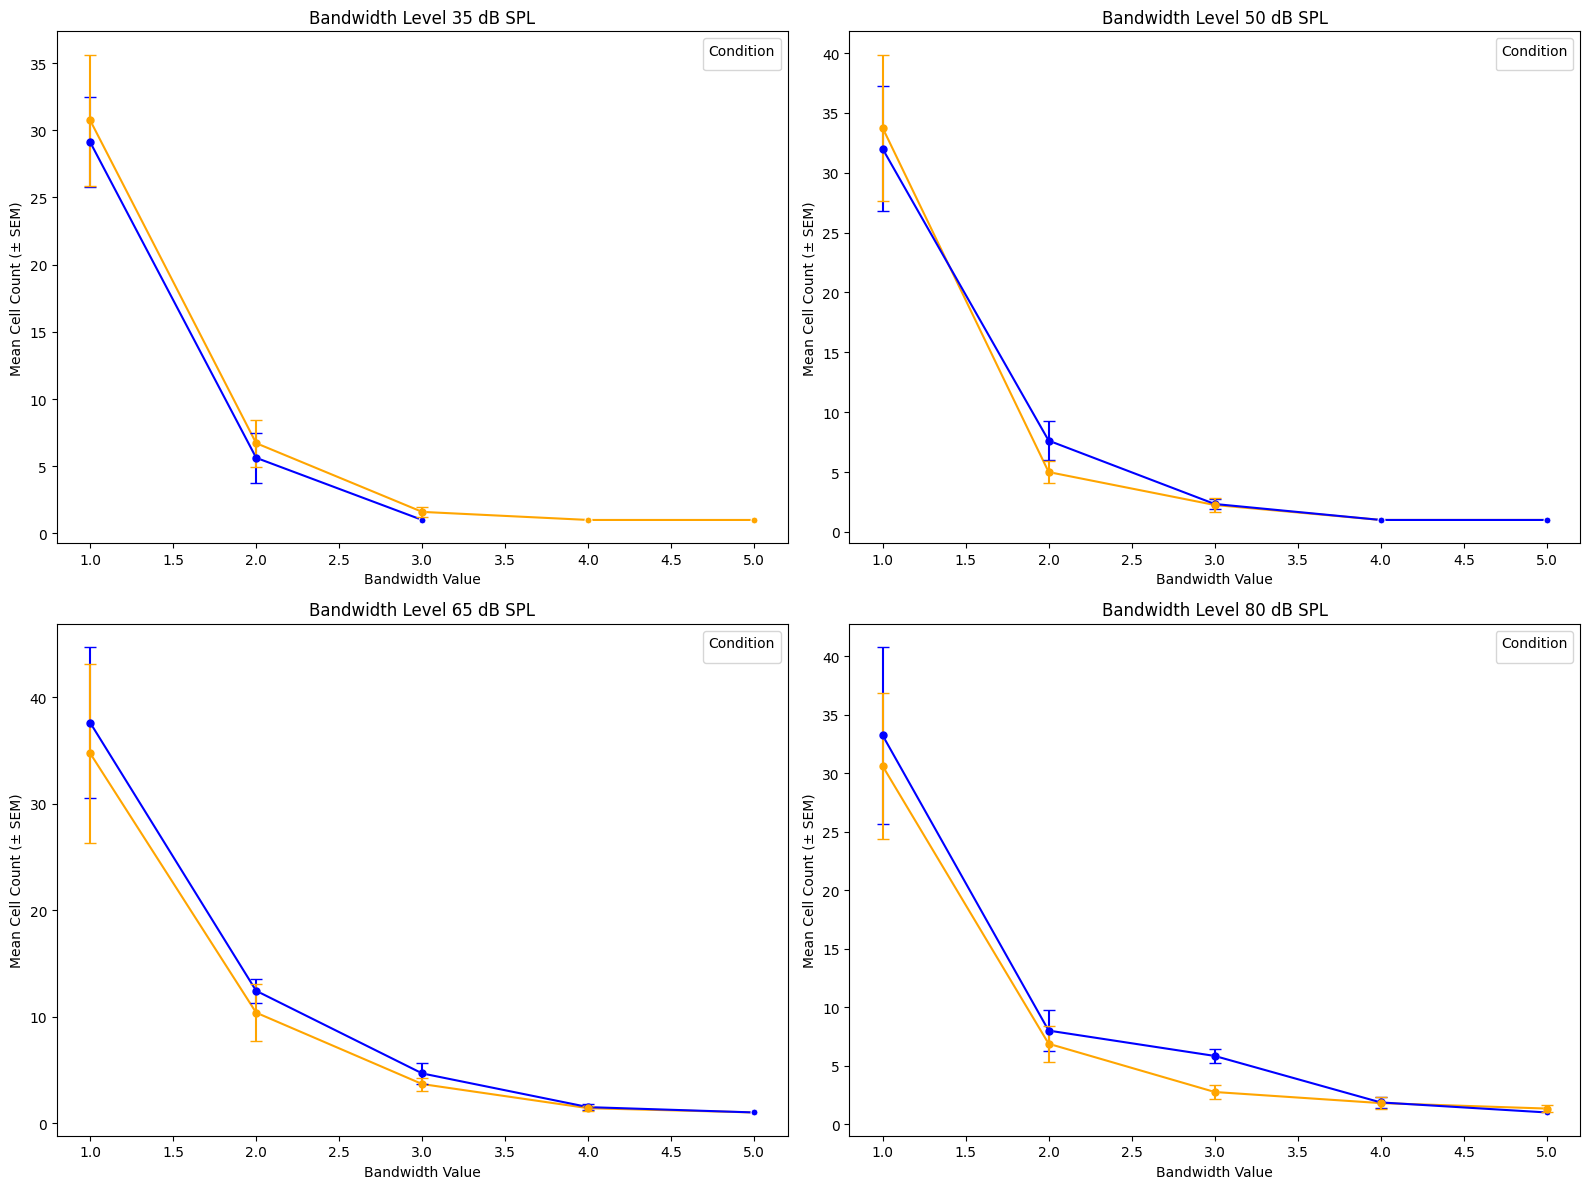

In [35]:
def plot_bandwidth_with_raw_counts(long_df):
    import matplotlib.pyplot as plt
    import seaborn as sns
    import numpy as np

    bandwidth_levels = [35, 50, 65, 80]
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.ravel()
    palette = {"pre": "b", "post": "#FFA500"}

    for i, level in enumerate(bandwidth_levels):
        ax = axes[i]

        # Filter for current bandwidth level, remove zeros, limit max to 5
        subset = long_df[
            (long_df['bandwidth_level'] == level) & 
            (long_df['bandwidth_value'] > 0) & 
            (long_df['bandwidth_value'] <= 5)
        ]

        # Count number of cells per bandwidth value, per mouse and condition
        count_df = subset.groupby(['condition', 'bandwidth_value', 'mouse_id']).size().reset_index(name='count')

        # Calculate mean and SEM per condition and bandwidth_value
        stats_df = count_df.groupby(['condition', 'bandwidth_value']).agg(
            mean_count=('count', 'mean'),
            sem=('count', lambda x: np.std(x, ddof=1) / np.sqrt(len(x)) if len(x) > 1 else 0)
        ).reset_index()

        # Plot
        sns.lineplot(
            data=stats_df,
            x='bandwidth_value', y='mean_count', hue='condition',
            marker='o', markersize=5, ax=ax, palette=palette, legend=False
        )

        # Add error bars
        for condition, color in palette.items():
            cond_data = stats_df[(stats_df['condition'] == condition) & (stats_df['sem'] > 0)]
            ax.errorbar(
                cond_data['bandwidth_value'], cond_data['mean_count'],
                yerr=cond_data['sem'], fmt='o', color=color, capsize=4, markersize=5
            )

        ax.set_title(f'Bandwidth Level {level} dB SPL')
        ax.set_xlabel('Bandwidth Value')
        ax.set_ylabel('Mean Cell Count (± SEM)')
        ax.set_xlim(0.8, 5.2)
        ax.legend(title='Condition')

    plt.tight_layout()
    plt.show()

plot_bandwidth_with_raw_counts(prepared_psilo)

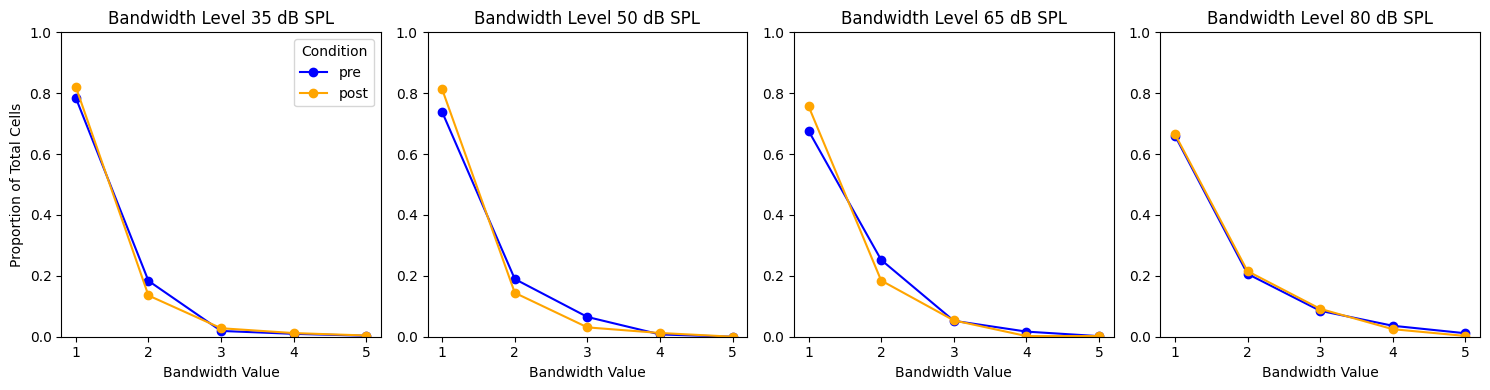

In [87]:
def plot_bandwidth_proportions_pooled(long_df):
    import matplotlib.pyplot as plt
    import numpy as np
    import pandas as pd
    import matplotlib.ticker as ticker

    bandwidth_levels = [35, 50, 65, 80]
    fig, axes = plt.subplots(1, 4, figsize=(15, 4))
    axes = axes.ravel()
    palette = {"pre": "b", "post": "#FFA500"}  # Orange for 'post'

    for i, level in enumerate(bandwidth_levels):
        ax = axes[i]

        # Filter for current bandwidth level, including bandwidths 1 to 5
        subset = long_df[
            (long_df['bandwidth_level'] == level) &
            (long_df['bandwidth_value'] >= 1) &
            (long_df['bandwidth_value'] <= 5)
        ]

        rows = []
        for condition in ['pre', 'post']:
            cond_subset = subset[subset['condition'] == condition]
            total_cells = len(cond_subset)
            if total_cells == 0:
                continue

            for bw in range(1, 6):
                count = np.sum(cond_subset['bandwidth_value'] == bw)
                prop = count / total_cells
                rows.append({
                    'condition': condition,
                    'bandwidth_value': bw,
                    'proportion': prop
                })

        plot_df = pd.DataFrame(rows)

        for condition, color in palette.items():
            cond_data = plot_df[plot_df['condition'] == condition]
            ax.plot(cond_data['bandwidth_value'], cond_data['proportion'], 
                    label=condition, color=color, marker='o', linestyle='-')

        ax.set_title(f'Bandwidth Level {level} dB SPL')
        ax.set_xlabel('Bandwidth Value')
        if i == 0:
            ax.set_ylabel('Proportion of Total Cells')
            ax.legend(title='Condition')

        ax.set_xlim(0.8, 5.2)
        ax.set_ylim(0, 1)
        ax.yaxis.set_major_locator(ticker.MultipleLocator(0.2))
        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.tight_layout()
    plt.show()

plot_bandwidth_proportions_pooled(prepared_saline)

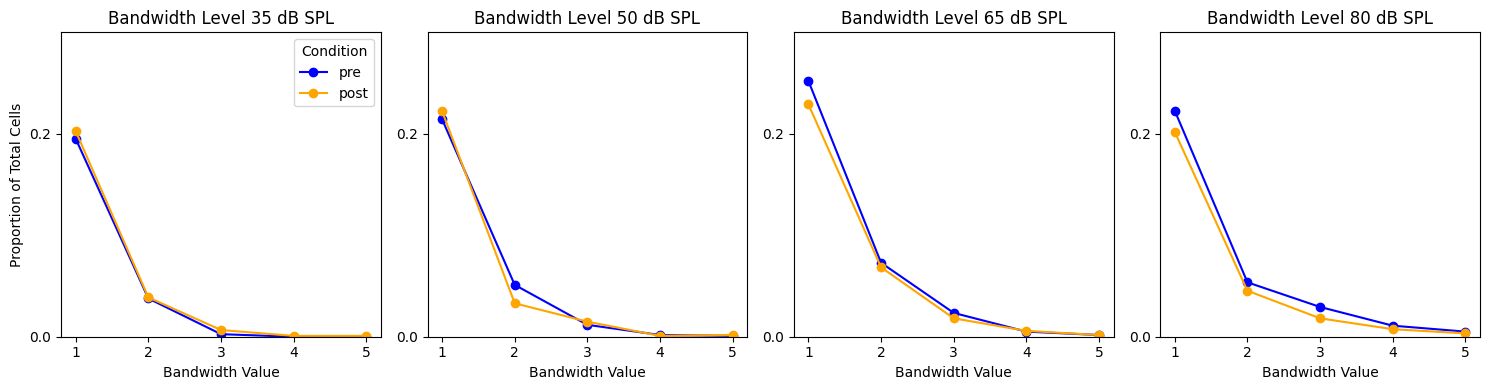

In [95]:
def plot_bandwidth_proportions_pooled_include_zeros(long_df):
    import matplotlib.pyplot as plt
    import numpy as np
    import pandas as pd
    import matplotlib.ticker as ticker

    bandwidth_levels = [35, 50, 65, 80]
    fig, axes = plt.subplots(1, 4, figsize=(15, 4))
    axes = axes.ravel()
    palette = {"pre": "b", "post": "#FFA500"}  # Orange for 'post'

    for i, level in enumerate(bandwidth_levels):
        ax = axes[i]

        # Filter data for this bandwidth level
        subset = long_df[long_df['bandwidth_level'] == level]

        rows = []
        for condition in ['pre', 'post']:
            cond_subset = subset[subset['condition'] == condition]
            total_cells = len(cond_subset)  # Includes zeros here!

            if total_cells == 0:
                continue

            for bw in range(1, 6):  # plot only bw 1-5
                count = np.sum(cond_subset['bandwidth_value'] == bw)
                prop = count / total_cells  # proportion of all cells (including zeros)
                rows.append({
                    'condition': condition,
                    'bandwidth_value': bw,
                    'proportion': prop
                })

        plot_df = pd.DataFrame(rows)

        for condition, color in palette.items():
            cond_data = plot_df[plot_df['condition'] == condition]
            ax.plot(cond_data['bandwidth_value'], cond_data['proportion'], 
                    label=condition, color=color, marker='o', linestyle='-')

        ax.set_title(f'Bandwidth Level {level} dB SPL')
        ax.set_xlabel('Bandwidth Value')
        if i == 0:
            ax.set_ylabel('Proportion of Total Cells')
            ax.legend(title='Condition')

        ax.set_xlim(0.8, 5.2)
        ax.set_ylim(0, 0.3)
        ax.yaxis.set_major_locator(ticker.MultipleLocator(0.2))
        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.tight_layout()
    plt.show()

plot_bandwidth_proportions_pooled_include_zeros(prepared_psilo)

C:\Users\Conor\AppData\Local\Temp\ipykernel_10524\1451277889.py:68: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(title='Condition')


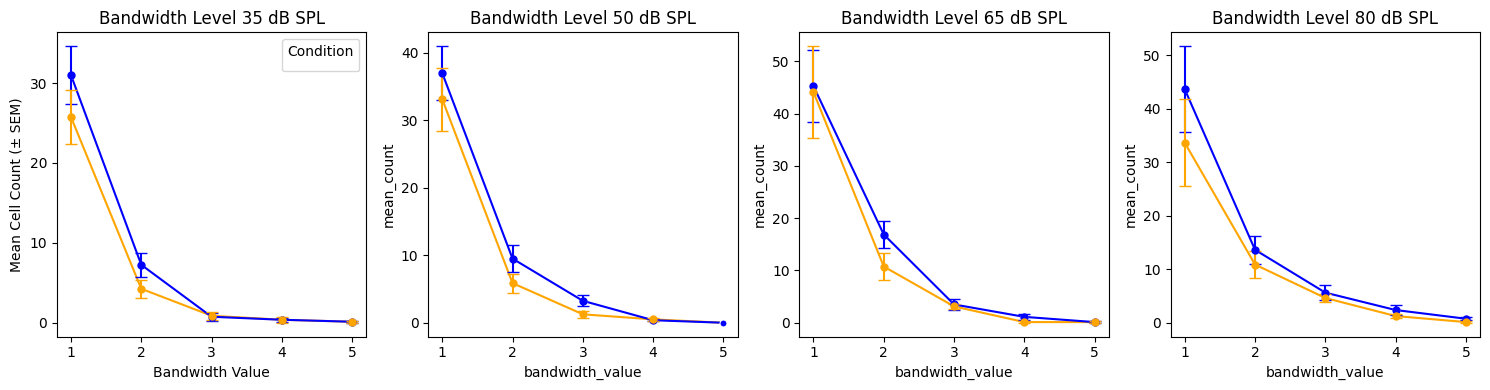

In [59]:
def plot_bandwidth_with_raw_counts(long_df):
    import matplotlib.pyplot as plt
    import seaborn as sns
    import numpy as np
    import pandas as pd
    import matplotlib.ticker as ticker

    bandwidth_levels = [35, 50, 65, 80]
    fig, axes = plt.subplots(1, 4, figsize=(15, 4))
    axes = axes.ravel()
    palette = {"pre": "b", "post": "#FFA500"}  # Orange for 'post'

    for i, level in enumerate(bandwidth_levels):
        ax = axes[i]

        # Filter for current bandwidth level, remove zeros, limit max to 5
        subset = long_df[
            (long_df['bandwidth_level'] == level) & 
            (long_df['bandwidth_value'] > 0) & 
            (long_df['bandwidth_value'] <= 5)
        ]

        # Count number of cells per bandwidth value, per mouse and condition
        count_df = subset.groupby(['condition', 'bandwidth_value', 'mouse_id']).size().reset_index(name='count')

        # Ensure all combinations exist — even zeros
        all_combos = pd.MultiIndex.from_product(
            [
                subset['condition'].unique(),
                range(1, 6),  # Bandwidth values from 1 to 5
                subset['mouse_id'].unique()
            ],
            names=['condition', 'bandwidth_value', 'mouse_id']
        )

        count_df = count_df.set_index(['condition', 'bandwidth_value', 'mouse_id']).reindex(all_combos, fill_value=0).reset_index()

        # Calculate mean and SEM per condition and bandwidth_value
        stats_df = count_df.groupby(['condition', 'bandwidth_value']).agg(
            mean_count=('count', 'mean'),
            sem=('count', lambda x: np.std(x, ddof=1) / np.sqrt(len(x)) if len(x) > 1 else 0)
        ).reset_index()

        # Plot
        sns.lineplot(
            data=stats_df,
            x='bandwidth_value', y='mean_count', hue='condition',
            marker='o', markersize=5, ax=ax, palette=palette, legend=False
        )

        # Add error bars
        for condition, color in palette.items():
            cond_data = stats_df[(stats_df['condition'] == condition) & (stats_df['sem'] > 0)]
            ax.errorbar(
                cond_data['bandwidth_value'], cond_data['mean_count'],
                yerr=cond_data['sem'], fmt='o', color=color, capsize=4, markersize=5
            )

        ax.set_title(f'Bandwidth Level {level} dB SPL')
        
        ax.yaxis.set_major_locator(ticker.MultipleLocator(10))
        ax.set_xlim(0.8, 5.2)
       
        if i == 0:
            ax.set_xlabel('Bandwidth Value')
            ax.set_ylabel('Mean Cell Count (± SEM)')
            
            ax.legend(title='Condition')


    plt.tight_layout()
    plt.show()

plot_bandwidth_with_raw_counts(prepared_saline)


C:\Users\Conor\AppData\Local\Temp\ipykernel_10524\579015256.py:48: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(title='Condition')


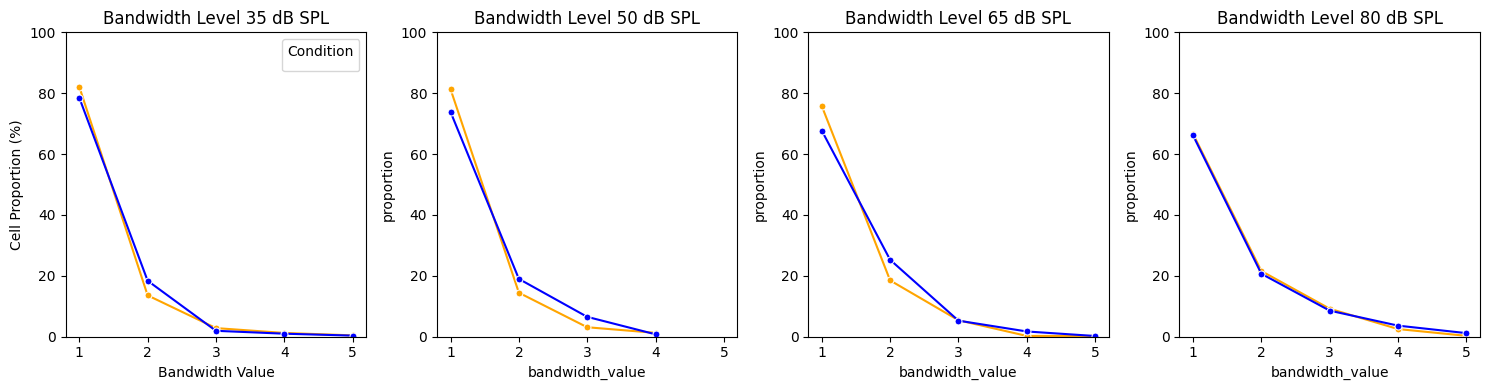

In [61]:
def plot_bandwidth_proportions_pooled(long_df):
    import matplotlib.pyplot as plt
    import seaborn as sns
    import numpy as np
    import pandas as pd
    import matplotlib.ticker as ticker

    bandwidth_levels = [35, 50, 65, 80]
    fig, axes = plt.subplots(1, 4, figsize=(15, 4))
    axes = axes.ravel()
    palette = {"pre": "b", "post": "#FFA500"}  # Orange for 'post'

    for i, level in enumerate(bandwidth_levels):
        ax = axes[i]

        # Filter for current bandwidth level, remove zeros, limit max to 5
        subset = long_df[
            (long_df['bandwidth_level'] == level) & 
            (long_df['bandwidth_value'] > 0) & 
            (long_df['bandwidth_value'] <= 5)
        ]

        # Count number of cells per condition and bandwidth_value
        count_df = subset.groupby(['condition', 'bandwidth_value']).size().reset_index(name='count')

        # Count total number of cells per condition
        total_df = subset.groupby('condition').size().reset_index(name='total')

        # Merge and calculate proportion
        prop_df = count_df.merge(total_df, on='condition')
        prop_df['proportion'] = 100 * prop_df['count'] / prop_df['total']

        # Plot
        sns.lineplot(
            data=prop_df,
            x='bandwidth_value', y='proportion', hue='condition',
            marker='o', markersize=5, ax=ax, palette=palette, legend=False
        )

        ax.set_title(f'Bandwidth Level {level} dB SPL')
        ax.set_xlim(0.8, 5.2)
        ax.set_ylim(0, 100)
        ax.yaxis.set_major_locator(ticker.MultipleLocator(20))

        if i == 0:
            ax.set_xlabel('Bandwidth Value')
            ax.set_ylabel('Cell Proportion (%)')
            ax.legend(title='Condition')

    plt.tight_layout()
    plt.show()

plot_bandwidth_proportions_pooled(prepared_saline)

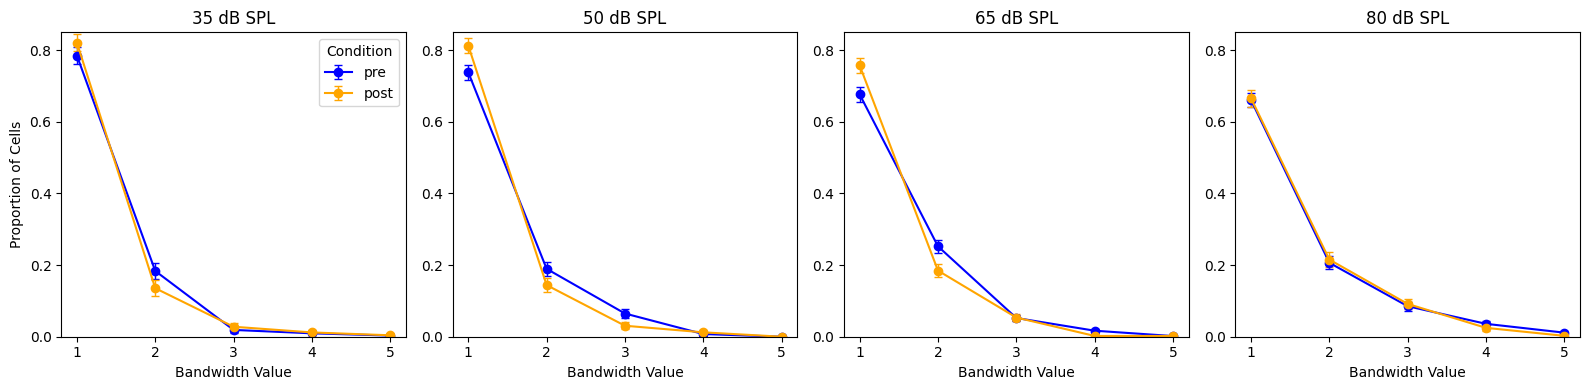

In [78]:
def plot_bandwidth_with_sem_cells(long_df):
    import matplotlib.pyplot as plt
    import numpy as np
    import pandas as pd
    from matplotlib.ticker import MultipleLocator

    bandwidth_levels = [35, 50, 65, 80]
    fig, axes = plt.subplots(1, 4, figsize=(16, 4))
    axes = axes.ravel()
    palette = {"pre": "b", "post": "#FFA500"}  # Blue for 'pre', Orange for 'post'

    for i, level in enumerate(bandwidth_levels):
        ax = axes[i]

        subset = long_df[
            (long_df['bandwidth_level'] == level) & 
            (long_df['bandwidth_value'] > 0) & 
            (long_df['bandwidth_value'] <= 5)
        ]

        rows = []

        for condition in ['pre', 'post']:
            cond_subset = subset[subset['condition'] == condition]

            for bw in range(1, 6):
                binary = (cond_subset['bandwidth_value'] == bw).astype(int).values
                n_cells = len(binary)
                if n_cells == 0:
                    mean_prop = np.nan
                    sem_prop = np.nan
                else:
                    mean_prop = np.mean(binary)
                    # SEM for binary proportion
                    sem_prop = np.sqrt(mean_prop * (1 - mean_prop) / n_cells)

                rows.append({
                    'condition': condition,
                    'bandwidth_value': bw,
                    'mean': mean_prop,
                    'sem': sem_prop
                })

        plot_df = pd.DataFrame(rows)

        for condition, color in palette.items():
            cond_data = plot_df[plot_df['condition'] == condition]
            ax.errorbar(
                cond_data['bandwidth_value'], 
                cond_data['mean'], 
                yerr=cond_data['sem'], 
                label=condition, 
                color=color, 
                marker='o', 
                linestyle='-',
                capsize=3,
                elinewidth=1,
                markeredgewidth=1
            )

        ax.set_title(f'{level} dB SPL')
        ax.set_xlabel('Bandwidth Value')
        if i == 0:
            ax.set_ylabel('Proportion of Cells')
        ax.set_xlim(0.8, 5.2)
        ax.set_ylim(0, 0.85)
        ax.yaxis.set_major_locator(MultipleLocator(0.2))
        ax.xaxis.set_major_locator(MultipleLocator(1))
        if i == 0:
            ax.legend(title='Condition')

    plt.tight_layout()
    plt.show()

plot_bandwidth_with_sem_cells(prepared_saline)

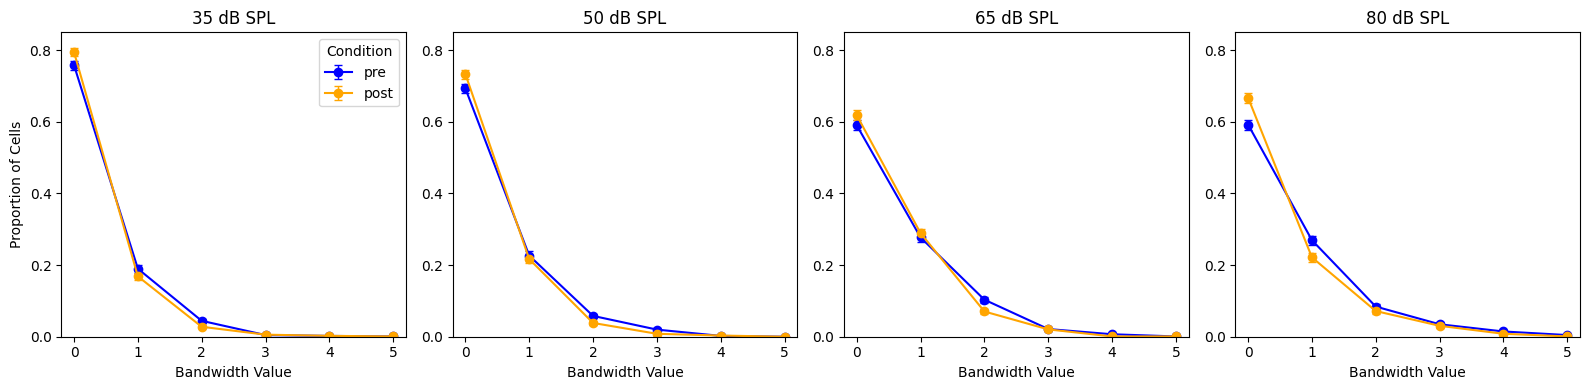

In [76]:
def plot_bandwidth_with_sem_cells_include_zero(long_df):
    import matplotlib.pyplot as plt
    import numpy as np
    import pandas as pd
    from matplotlib.ticker import MultipleLocator

    bandwidth_levels = [35, 50, 65, 80]
    fig, axes = plt.subplots(1, 4, figsize=(16, 4))
    axes = axes.ravel()
    palette = {"pre": "b", "post": "#FFA500"}  # Blue for 'pre', Orange for 'post'

    for i, level in enumerate(bandwidth_levels):
        ax = axes[i]

        # Include zero bandwidth values, so remove the '> 0' filter
        subset = long_df[
            (long_df['bandwidth_level'] == level) & 
            (long_df['bandwidth_value'] >= 0) &  # now >=0 to include zeros
            (long_df['bandwidth_value'] <= 5)
        ]

        rows = []

        for condition in ['pre', 'post']:
            cond_subset = subset[subset['condition'] == condition]

            # Now range from 0 to 5 inclusive
            for bw in range(0, 6):
                binary = (cond_subset['bandwidth_value'] == bw).astype(int).values
                n_cells = len(binary)
                if n_cells == 0:
                    mean_prop = np.nan
                    sem_prop = np.nan
                else:
                    mean_prop = np.mean(binary)
                    sem_prop = np.sqrt(mean_prop * (1 - mean_prop) / n_cells)

                rows.append({
                    'condition': condition,
                    'bandwidth_value': bw,
                    'mean': mean_prop,
                    'sem': sem_prop
                })

        plot_df = pd.DataFrame(rows)

        for condition, color in palette.items():
            cond_data = plot_df[plot_df['condition'] == condition]
            ax.errorbar(
                cond_data['bandwidth_value'], 
                cond_data['mean'], 
                yerr=cond_data['sem'], 
                label=condition, 
                color=color, 
                marker='o', 
                linestyle='-',
                capsize=3,
                elinewidth=1,
                markeredgewidth=1
            )

        ax.set_title(f'{level} dB SPL')
        ax.set_xlabel('Bandwidth Value')
        if i == 0:
            ax.set_ylabel('Proportion of Cells')
        ax.set_xlim(-0.2, 5.2)  # allow a bit of padding for zero
        ax.set_ylim(0, 0.85)
        ax.yaxis.set_major_locator(MultipleLocator(0.2))
        ax.xaxis.set_major_locator(MultipleLocator(1))
        if i == 0:
            ax.legend(title='Condition')

    plt.tight_layout()
    plt.show()

plot_bandwidth_with_sem_cells_include_zero(prepared_saline)

C:\Users\Conor\AppData\Local\Temp\ipykernel_11952\2309921559.py:52: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(title='Condition')
C:\Users\Conor\AppData\Local\Temp\ipykernel_11952\2309921559.py:52: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(title='Condition')
C:\Users\Conor\AppData\Local\Temp\ipykernel_11952\2309921559.py:52: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(title='Condition')
C:\Users\Conor\AppData\Local\Temp\ipykernel_11952\2309921559.py:52: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignor

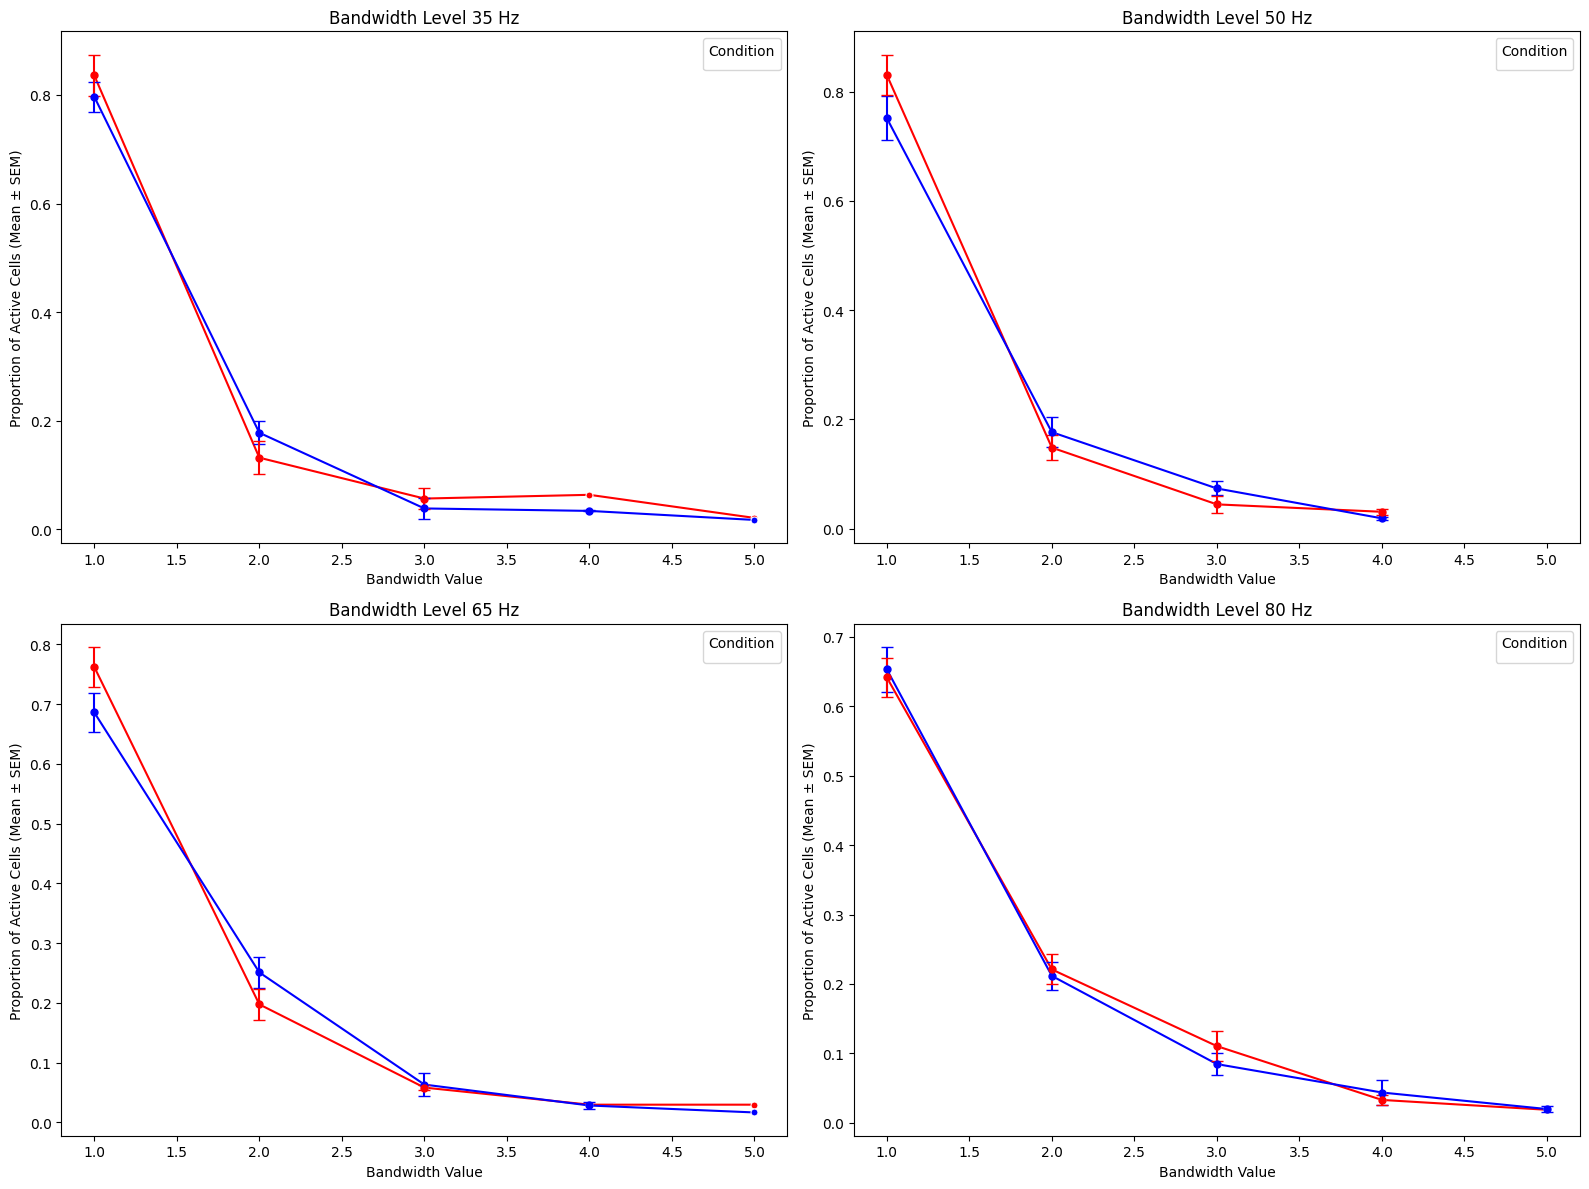

In [20]:
def plot_bandwidth_with_error_bars(long_df):
    bandwidth_levels = [35, 50, 65, 80]
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.ravel()
    palette = {"pre": "b", "post": "r"}

    for i, level in enumerate(bandwidth_levels):
        ax = axes[i]
        
        # Filter for current bandwidth level, exclude zeros, limit max bandwidth_value to 5
        subset = long_df[
            (long_df['bandwidth_level'] == level) &
            (long_df['bandwidth_value'] > 0) &
            (long_df['bandwidth_value'] <= 5)
        ]
        
        # Total active cells per mouse and condition (within this bandwidth level)
        total_cells = subset.groupby(['condition', 'mouse_id']).size().reset_index(name='total_count')
        
        # Count frequency per bandwidth value, mouse, and condition
        count_df = subset.groupby(['condition', 'bandwidth_value', 'mouse_id']).size().reset_index(name='count')
        
        # Merge total counts for each mouse & condition to compute proportion
        count_df = count_df.merge(total_cells, on=['condition', 'mouse_id'])
        count_df['proportion'] = count_df['count'] / count_df['total_count']
        
        # Calculate mean and SEM of proportions per condition and bandwidth_value
        stats_df = count_df.groupby(['condition', 'bandwidth_value']).agg(
            mean_prop=('proportion', 'mean'),
            sem=('proportion', lambda x: np.std(x, ddof=1) / np.sqrt(len(x)) if len(x) > 1 else 0)
        ).reset_index()
        
        # Plot mean proportions
        sns.lineplot(
            data=stats_df,
            x='bandwidth_value', y='mean_prop', hue='condition',
            marker='o', markersize=5, ax=ax, palette=palette, legend=False
        )
        
        # Add error bars where SEM > 0
        for condition, color in palette.items():
            cond_data = stats_df[(stats_df['condition'] == condition) & (stats_df['sem'] > 0)]
            ax.errorbar(
                cond_data['bandwidth_value'], cond_data['mean_prop'],
                yerr=cond_data['sem'], fmt='o', color=color, capsize=4, markersize=5
            )
        
        ax.set_title(f'Bandwidth Level {level} Hz')
        ax.set_xlabel('Bandwidth Value')
        ax.set_ylabel('Proportion of Active Cells (Mean ± SEM)')
        ax.set_xlim(0.8, 5.2)
        ax.legend(title='Condition')

    plt.tight_layout()
    plt.show()

    
plot_bandwidth_with_error_bars(prepared_saline)

C:\Users\Conor\AppData\Local\Temp\ipykernel_10524\754243174.py:55: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(title='Condition')
C:\Users\Conor\AppData\Local\Temp\ipykernel_10524\754243174.py:55: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(title='Condition')
C:\Users\Conor\AppData\Local\Temp\ipykernel_10524\754243174.py:55: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(title='Condition')
C:\Users\Conor\AppData\Local\Temp\ipykernel_10524\754243174.py:55: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored w

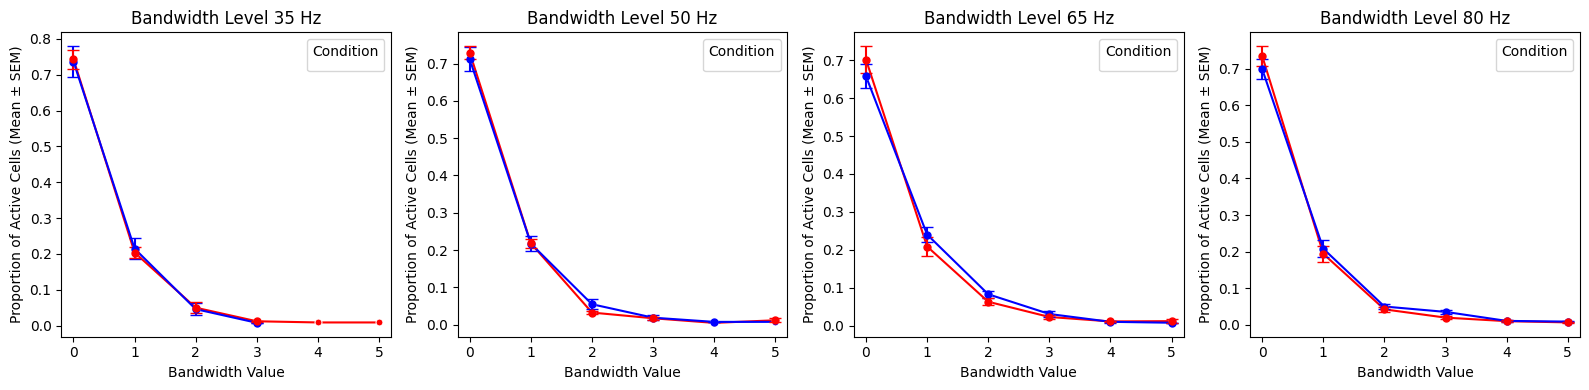

In [85]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_bandwidth_with_error_bars(long_df):
    bandwidth_levels = [35, 50, 65, 80]
    fig, axes = plt.subplots(1, 4, figsize=(16, 4))
    axes = axes.ravel()
    palette = {"pre": "b", "post": "r"}

    for i, level in enumerate(bandwidth_levels):
        ax = axes[i]
        
        # Filter for current bandwidth level, limit max bandwidth_value to 5
        subset = long_df[
            (long_df['bandwidth_level'] == level) &
            (long_df['bandwidth_value'] <= 5)
        ]
        
        # Total active cells per mouse and condition (within this bandwidth level)
        total_cells = subset.groupby(['condition', 'mouse_id']).size().reset_index(name='total_count')
        
        # Count frequency per bandwidth value, mouse, and condition
        count_df = subset.groupby(['condition', 'bandwidth_value', 'mouse_id']).size().reset_index(name='count')
        
        # Merge total counts for each mouse & condition to compute proportion
        count_df = count_df.merge(total_cells, on=['condition', 'mouse_id'])
        count_df['proportion'] = count_df['count'] / count_df['total_count']
        
        # Calculate mean and SEM of proportions per condition and bandwidth_value
        stats_df = count_df.groupby(['condition', 'bandwidth_value']).agg(
            mean_prop=('proportion', 'mean'),
            sem=('proportion', lambda x: np.std(x, ddof=1) / np.sqrt(len(x)) if len(x) > 1 else 0)
        ).reset_index()
        
        # Plot mean proportions
        sns.lineplot(
            data=stats_df,
            x='bandwidth_value', y='mean_prop', hue='condition',
            marker='o', markersize=5, ax=ax, palette=palette, legend=False
        )
        
        # Add error bars where SEM > 0
        for condition, color in palette.items():
            cond_data = stats_df[(stats_df['condition'] == condition) & (stats_df['sem'] > 0)]
            ax.errorbar(
                cond_data['bandwidth_value'], cond_data['mean_prop'],
                yerr=cond_data['sem'], fmt='o', color=color, capsize=4, markersize=5
            )
        
        ax.set_title(f'Bandwidth Level {level} Hz')
        ax.set_xlabel('Bandwidth Value')
        ax.set_ylabel('Proportion of Active Cells (Mean ± SEM)')
        ax.set_xlim(-0.2, 5.2)  # Pad the x-axis a bit on either side
        ax.legend(title='Condition')

    plt.tight_layout()
    plt.show()

plot_bandwidth_with_error_bars(prepared_psilo)

In [29]:
pre_saline = saline_data[saline_data['condition'] == 'pre']
pre_saline['treatment'] = 'saline'
pre_psilo = psilo_data[psilo_data['condition'] == 'pre']
pre_psilo['treatment'] = 'psilocybin'

pre_all = pd.concat([pre_saline,pre_psilo],ignore_index=True)

C:\Users\Conor\AppData\Local\Temp\ipykernel_16400\3180880504.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pre_saline['treatment'] = 'saline'
C:\Users\Conor\AppData\Local\Temp\ipykernel_16400\3180880504.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pre_psilo['treatment'] = 'psilocybin'


In [54]:
# Create separate dataframes for each bandwidth level
bandwidth_levels = [35, 50, 65, 80]
results = {}
print("Pre vs Pre Data Results")
for bw in bandwidth_levels:
    # Filter data for this bandwidth level
    bw_data = pre_all[['mouse_id', 'unique_cell_id', 'treatment', f'bandwidth_{bw}']]
    
    # Rename for clarity
    bw_data = bw_data.rename(columns={f'bandwidth_{bw}': 'bandwidth_value'})
    
    # Fit model for this bandwidth level
    model = smf.mixedlm(
        "bandwidth_value ~ treatment", 
        bw_data, 
        groups=bw_data["mouse_id"]
    )
    
    try:
        # Store results if convergence successful
        results[bw] = model.fit()
        print(f"\nResults for bandwidth {bw}:")
        print(results[bw].summary().tables[1])  # Print only coefficients table
    except:
        print(f"\nConvergence failed for bandwidth {bw}")

Pre vs Pre Data Results

Results for bandwidth 35:
                     Coef. Std.Err.      z  P>|z|  [0.025 0.975]
Intercept            0.325    0.072  4.500  0.000   0.183  0.466
treatment[T.saline]  0.029    0.024  1.236  0.217  -0.017  0.076
Group Var            0.039    0.036                             

Results for bandwidth 50:
                     Coef. Std.Err.      z  P>|z|  [0.025 0.975]
Intercept            0.394    0.064  6.150  0.000   0.268  0.519
treatment[T.saline]  0.050    0.027  1.858  0.063  -0.003  0.103
Group Var            0.030    0.025                             

Results for bandwidth 65:
                     Coef. Std.Err.      z  P>|z| [0.025 0.975]
Intercept            0.500    0.062  8.113  0.000  0.379  0.621
treatment[T.saline]  0.084    0.033  2.546  0.011  0.019  0.149
Group Var            0.026    0.019                            

Results for bandwidth 80:
                     Coef. Std.Err.       z  P>|z| [0.025 0.975]
Intercept            0.530 

In [ ]:
# Your bandwidth levels
bandwidth_levels = [35, 50, 65, 80]
pvalues = []
coefs = []
stderr = []

# Use the correct parameter name: 'condition[T.pre]'
param_name = 'treatment[T.saline]'
for bw in bandwidth_levels:
    try:
        # Extract p-value, coefficient, and standard error
        pvalues.append(results[bw].pvalues[param_name])
        coefs.append(results[bw].params[param_name])
        stderr.append(results[bw].bse[param_name])
    except KeyError:
        print(f"Parameter '{param_name}' not found for bandwidth {bw}")
        # Print available parameters to help debug
        print(f"Available parameters: {results[bw].params.index.tolist()}")
        pvalues.append(np.nan)
        coefs.append(np.nan)
        stderr.append(np.nan)

# Remove any NaN values before applying FDR correction
valid_indices = ~np.isnan(pvalues)
valid_pvals = [p for i, p in enumerate(pvalues) if valid_indices[i]]

if valid_pvals:
    # Apply FDR correction
    reject, pvals_corrected, _, _ = multipletests(valid_pvals, method='fdr_bh', alpha=0.05)
    
    # Put corrected values back in original order
    all_pvals_corrected = [np.nan] * len(pvalues)
    all_reject = [False] * len(pvalues)
    
    j = 0
    for i in range(len(pvalues)):
        if valid_indices[i]:
            all_pvals_corrected[i] = pvals_corrected[j]
            all_reject[i] = reject[j]
            j += 1
else:
    print("No valid p-values found for FDR correction")
    all_pvals_corrected = [np.nan] * len(pvalues)
    all_reject = [False] * len(pvalues)

# Create summary table
results_table = pd.DataFrame({
    'Bandwidth': bandwidth_levels,
    'Coefficient': coefs,
    'Std_Error': stderr,
    'Original_p': pvalues,
    'FDR_p': all_pvals_corrected,
    'Significant': all_reject
})

print("\nResults after FDR correction:")
print(results_table)

# Create a more detailed report
print("\nDetailed summary:")
for i, bw in enumerate(bandwidth_levels):
    if np.isnan(pvalues[i]):
        print(f"\nBandwidth {bw}: No valid results")
        continue
        
    sig_status = "significant" if all_reject[i] else "not significant"
    print(f"\nBandwidth {bw}:")
    print(f"  Effect of treatment[T.saline]: {coefs[i]:.4f} ± {stderr[i]:.4f}")
    print(f"  Original p-value: {pvalues[i]:.4f}")
    print(f"  FDR-corrected p-value: {all_pvals_corrected[i]:.4f}")
    print(f"  Result: {sig_status} after FDR correction")


Results after FDR correction:
   Bandwidth  Coefficient  Std_Error  Original_p     FDR_p  Significant
0         35     0.029462   0.023843    0.216597  0.216597        False
1         50     0.050177   0.027013    0.063238  0.084317        False
2         65     0.084213   0.033081    0.010907  0.021814         True
3         80     0.161879   0.043281    0.000184  0.000735         True

Detailed summary:

Bandwidth 35:
  Effect of condition[T.pre]: 0.0295 ± 0.0238
  Original p-value: 0.2166
  FDR-corrected p-value: 0.2166
  Result: not significant after FDR correction

Bandwidth 50:
  Effect of condition[T.pre]: 0.0502 ± 0.0270
  Original p-value: 0.0632
  FDR-corrected p-value: 0.0843
  Result: not significant after FDR correction

Bandwidth 65:
  Effect of condition[T.pre]: 0.0842 ± 0.0331
  Original p-value: 0.0109
  FDR-corrected p-value: 0.0218
  Result: significant after FDR correction

Bandwidth 80:
  Effect of condition[T.pre]: 0.1619 ± 0.0433
  Original p-value: 0.0002
  FDR

C:\Users\Conor\AppData\Local\Temp\ipykernel_2972\3306105816.py:44: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([str(0.5 * i) for i in range(6)])


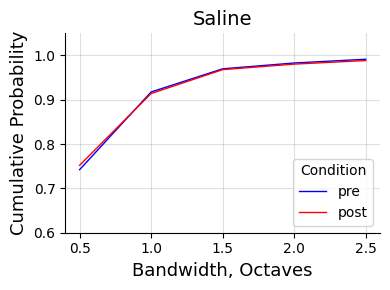

In [107]:
def plot_mean_bandwidth_cdfs(long_df):
    import numpy as np
    import matplotlib.pyplot as plt

    fig, ax = plt.subplots(figsize=(4, 3))
    palette = {"pre": "b", "post": "r"}

    # Filter valid bandwidths
    subset = long_df[
        (long_df['bandwidth_value'] > 0) &
        (long_df['bandwidth_value'] <= 9)
    ]

    # Group by condition and mouse
    grouped = subset.groupby(['condition', 'mouse_id'])

    # Prepare x values for CDF (bandwidth 1 to 5)
    x_vals = np.arange(1, 6)

    for condition in ['pre', 'post']:
        mouse_groups = [
            group['bandwidth_value'].values
            for (cond, _), group in grouped
            if cond == condition
        ]

        cdf_matrix = []
        for vals in mouse_groups:
            if len(vals) > 0:
                cdf = [(vals <= x).sum() / len(vals) for x in x_vals]
                cdf_matrix.append(cdf)

        if cdf_matrix:
            mean_cdf = np.mean(cdf_matrix, axis=0)
            ax.plot(x_vals, mean_cdf, lw=1, color=palette[condition], label=condition)

    ax.set_title('Saline',size=14)
    ax.set_xlabel('Bandwidth, Octaves',size=13)
    ax.set_ylabel('Cumulative Probability',size=13)
    # ax.set_xlim(0.8, 5.2)
    ax.set_ylim(0.6, 1.05)
    ax.legend(title='Condition')
    ax.grid(alpha=0.4)
    ax.set_xticklabels([str(0.5 * i) for i in range(6)])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    plt.tight_layout()
    plt.show()

plot_mean_bandwidth_cdfs(prepared_psilo)

In [82]:
def compute_icc(df, value_col='bandwidth_50', group_col='mouse_id'):
    import statsmodels.formula.api as smf

    # Filter valid (nonzero) values
    df = df[df[value_col] > 0].copy()
    
    # Fit random-intercept mixed model
    model = smf.mixedlm(f"{value_col} ~ 1", df, groups=df[group_col])
    result = model.fit(method='nm')
    
    # Variance components
    var_between = result.cov_re.iloc[0, 0]  # Mouse-level (random intercept)
    var_within = result.scale               # Residual/error variance
    var_total = var_between + var_within

    # ICC and proportions
    icc = var_between / var_total
    prop_between = var_between / var_total
    prop_within = var_within / var_total

    return {
        'ICC': icc,
        'var_between': var_between,
        'var_within': var_within,
        'var_total': var_total,
        'prop_between': prop_between,
        'prop_within': prop_within
    }

print(compute_icc(rows_pre_saline))

{'ICC': 0.04512298744090317, 'var_between': 0.018186942677696157, 'var_within': 0.38486577411139705, 'var_total': 0.4030527167890932, 'prop_between': 0.04512298744090317, 'prop_within': 0.9548770125590968}


C:\Users\Conor\AppData\Local\Temp\ipykernel_11952\337122420.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap('tab20', len(all_mouse_ids))


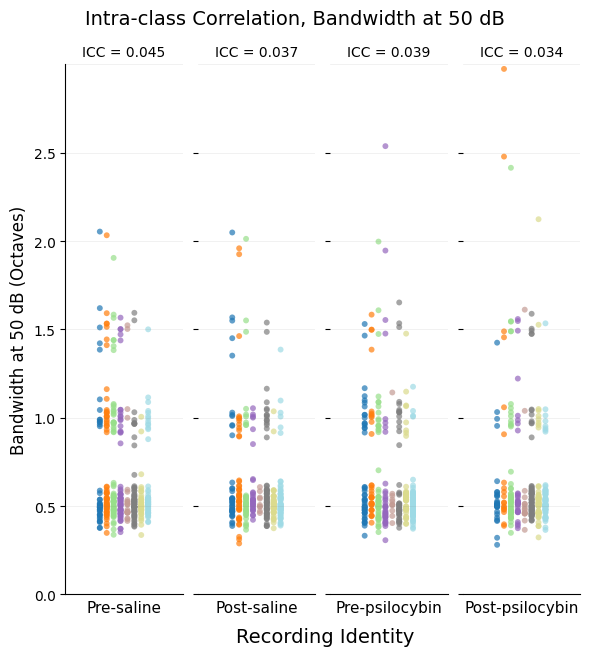

In [83]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
import matplotlib.colors as mcolors

# Your four condition-specific DataFrames
dataframes = [rows_pre_saline, rows_post_saline, rows_pre_psilo, rows_post_psilo]
titles = ['ICC = 0.045', 'ICC = 0.037', 'ICC = 0.039', 'ICC = 0.034']
Xtitles = ['Pre-saline', 'Post-saline', 'Pre-psilocybin', 'Post-psilocybin']

# Get all unique mouse IDs across all dataframes
all_mouse_ids = sorted(set(np.concatenate([df['mouse_id'].unique() for df in dataframes])))

# Create a color map using tab20 (up to 20 unique mice)
cmap = cm.get_cmap('tab20', len(all_mouse_ids))
color_map = {mouse_id: cmap(i) for i, mouse_id in enumerate(all_mouse_ids)}

# Set up the plot
fig, axes = plt.subplots(1, 4, figsize=(6, 6), sharey=True)

for idx, (df, ax, title, Xtitle) in enumerate(zip(dataframes, axes, titles, Xtitles)):
    
    unique_mice = sorted(df['mouse_id'].unique())
    x_positions = np.arange(len(unique_mice)) * 0.1

    for i, mouse in enumerate(unique_mice):
        # Filter cells with bandwidth_65 > 0
        mouse_data = df[(df['mouse_id'] == mouse) & (df['bandwidth_50'] > 0)]['bandwidth_50'].values
        
        if len(mouse_data) == 0:
            continue
        
        y_jitter = np.random.normal(0, 0.12, size=len(mouse_data))
        y_coords = mouse_data + y_jitter
        x_coords = np.full(len(mouse_data), x_positions[i])
        
        ax.scatter(
            x_coords,
            y_coords,
            alpha=0.7,
            s=18,
            color=color_map[mouse],
            edgecolors='none'
        )

    # Horizontal reference lines
    for level in range(10):
        ax.axhline(y=level, color='gray', linestyle='-', alpha=0.15, linewidth=0.5)

    ax.set_title(title, fontsize=10)
    ax.set_xlabel(Xtitle, fontsize=11)

    if idx == 0:
        ax.set_ylabel('Bandwidth at 50 dB (Octaves)', fontsize=12)
        ax.set_yticks(range(0, 6))
        ax.set_yticklabels([str(0.5 * i) for i in range(6)])  # 0.0 to 3.0
    else:
        ax.spines['left'].set_visible(False)

    ax.set_xlim(-0.5, max(x_positions) + 0.5)
    ax.set_xticks([])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_ylim(0, 6)

# Add global titles
fig.text(0.55, -0.02, 'Recording Identity', ha='center', fontsize=14)
fig.text(0.5, 1.01, 'Intra-class Correlation, Bandwidth at 50 dB', ha='center', fontsize=14)

plt.tight_layout()
plt.show()

In [130]:
BASE_PATH = 'C:/Users/Conor/Documents/GitHub/'

iscell_logical = np.load(BASE_PATH + "iscell.npy",allow_pickle=True) 
stat = np.load(BASE_PATH + 'stat.npy',allow_pickle=True)

In [ ]:
print(stat[0]['med'])
cell_indices = np.where(iscell_logical[:, 0] == 1)[0]


[107, 259]
[   0    1    2    3    4    5    6    7    8    9   10   11   12   13
   14   15   16   17   18   19   20   21   22   23   24   25   26   27
   28   29   30   31   32   33   34   35   36   37   38   39   40   41
   42   43   44   45   46   47   48   49   50   51   52   53   54   55
   56   57   58   59   60   61   62   63   64   65   66   67   68   69
   70   71   72   73   74   75   76   77   78   79   80   81   82   83
   84   85   86   87   88   89   90   91   92   93   94   95   96   97
   98   99  100  101  102  103  104  105  106  107  108  109  110  111
  112  113  114  115  116  117  118  119  120  121  122  123  124  125
  126  127  128  129  130  131  133  134  135  136  137  138  139  140
  141  142  143  144  145  146  147  148  149  150  151  152  153  154
  157  158  159  160  161  162  163  164  166  167  169  170  171  172
  173  174  175  176  177  178  179  182  183  184  185  186  187  188
  189  190  191  192  193  194  195  196  198  200  202  203  205 

In [ ]:
coords = [stat[i]['med'] for i in cell_indices]




[263, 395]


In [145]:
cellspath = 'C:/Users/Conor/Documents/GitHub/cells.pkl'

with open(cellspath, 'rb') as file:
    cells = pickle.load(file)

In [150]:
print(cells[2]['coords'])

[263, 395]
